# Chap.08 実践編 ロジスティック回帰モデル（2値分類）

In [27]:
# ライブラリの準備
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'IPAexgothic'
# plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')
%matplotlib inline

## 8.1 例題の問題設定

## 8.2 回帰モデルと分類モデルの違い

## 8.3 予測モデルの検討

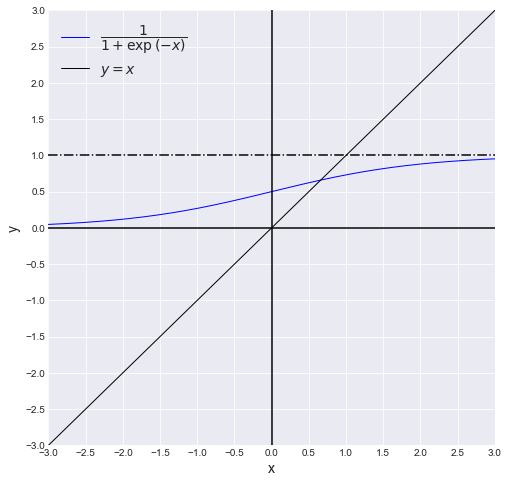

In [28]:
# 図8-4 シグモイド関数のグラフ

xx = np.linspace(-6, 6, 500)
yy = 1 / (np.exp(-xx) + 1)

plt.figure(figsize=(8, 8))
plt.ylim(-3, 3)
plt.xlim(-3, 3)
plt.xticks(np.linspace(-3, 3, 13))
plt.yticks(np.linspace(-3, 3, 13))
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.grid(True)
plt.plot(xx, yy, c='b', label=r'$\dfrac{1}{1+\exp{(-x)}}$', lw=1)
plt.plot(xx, xx, c='k', label=r'$y = x$', lw=1)
plt.plot([-3, 3], [0, 0], c='k')
plt.plot([0, 0], [-3, 3], c='k')
plt.plot([-3, 3], [1, 1], linestyle='-.', c='k')
plt.legend(fontsize=14)
plt.show()


## 8.4 損失関数（交差エントロピー関数）

## 8.5 損失関数の微分計算

## 8.6 勾配降下法の適用

## 8.7 プログラムの実装

In [29]:
# 学習用データ準備
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org = iris.data, iris.target
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


In [30]:
# データ絞り込み
#   クラス0, 1のみ
#   項目sepal_lengthとsepal_widthのみ
x_data, y_data = iris.data[:100, :2], iris.target[:100]
print('対象データ', x_data.shape, y_data.shape)

対象データ (100, 2) (100,)


In [31]:
# ダミー変数を追加
x_data = np.insert(x_data, 0, 1.0, axis=1)
print('ダミー変数追加後', x_data.shape)

ダミー変数追加後 (100, 3)


In [32]:
# 元データのサイズ
from sklearn.model_selection import train_test_split
print(x_data.shape, y_data.shape)
# 学習データ、検証データに分割 (シャフルも同時に実施)
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, train_size=70, test_size=30,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 3) (100,)
(70, 3) (30, 3) (70,) (30,)


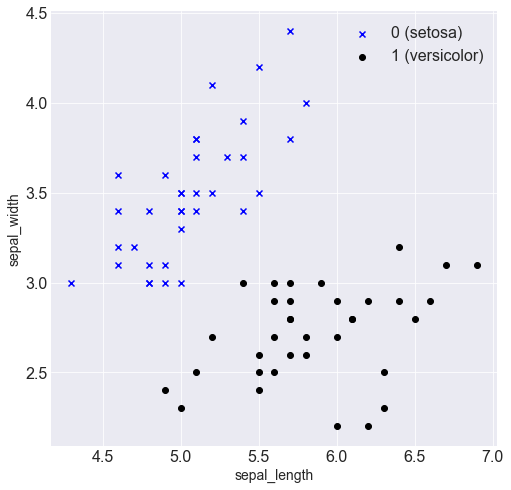

In [33]:
# 散布図の表示
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.figure(figsize=(8, 8))
plt.scatter(x_t0[:, 1], x_t0[:, 2], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:, 1], x_t1[:, 2], marker='o', c='k', label='1 (versicolor)')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('sepal_width', fontsize=14)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

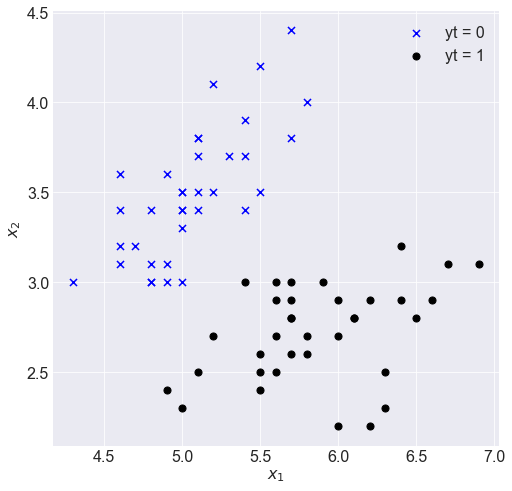

In [34]:
# 散布図の表示
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
plt.figure(figsize=(8, 8))
plt.scatter(x_t0[:, 1], x_t0[:, 2], marker='x', s=50, c='b', label='yt = 0')
plt.scatter(x_t1[:, 1], x_t1[:, 2], marker='o', s=50, c='k', label='yt = 1')
plt.xlabel(r'$x_1$', fontsize=16)
plt.ylabel(r'$x_2$', fontsize=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

In [35]:
# 学習用変数の設定
x = x_train
yt = y_train

In [36]:
# 入力データ x の表示 (ダミーデータを含む)
print(x[:5])

[[1.  5.1 3.7]
 [1.  5.5 2.6]
 [1.  5.5 4.2]
 [1.  5.6 2.5]
 [1.  5.4 3. ]]


In [37]:
# 正解値 yt の表示
print(yt[:5])

[0 1 0 1 1]


予測関数

In [38]:
# シグモイド関数
def sigmoid(x):
    return 1/(1+ np.exp(-x))

In [39]:
# 予測値の計算
def pred(x, w):
    return sigmoid(x @ w)

評価

In [40]:
# 損失関数(交差エントロピー関数)
def cross_entropy(yt, yp):
    # 交差エントロピーの計算(この段階ではベクトル)
    ce1 = -(yt * np.log(yp) + (1 - yt) * np.log(1 - yp))
    # 交差エントロピーベクトルの平均値を計算
    return(np.mean(ce1))

In [41]:
# 予測結果の確率値から 0 or 1 を判断する関数
def classify(y):
    return np.where(y < 0.5, 0, 1)

In [42]:
# モデルの評価を行う関数
from sklearn.metrics import accuracy_score

def evaluate(xt, yt, w):

    # 予測値の計算
    yp = pred(xt, w)

    # 損失関数値の計算
    loss = cross_entropy(yt, yp)

    # 予測値(確率値)を0または1に変換
    yp_b = classify(yp)

    #精度の算出
    score = accuracy_score(yt, yp_b)
    return loss, score

In [43]:
# 初期化処理

# 標本数
M  = x.shape[0]
# 入力次元数(ダミー変数を含む)
D = x.shape[1]

# 繰り返し回数
iters = 10000

# 学習率
alpha = 0.01

# 初期値
w = np.ones(D)

# 評価結果記録用 (損失関数と精度)
history = np.zeros((0, 3))

In [44]:
# 繰り返しループ

for k in range(iters):

    # 予測値の計算 (8.6.1) (8.6.2)
    yp = pred(x, w)

    # 誤差の計算 (8.6.4)
    yd = yp - yt

    # 勾配降下法の実施 (8.6.6)
    w = w - alpha * (x.T @ yd) / M

    # ログ記録用
    if (k % 10 == 0):
        loss, score = evaluate(x_test, y_test, w)
        history = np.vstack((
            history, np.array([k, loss, score])
        ))
        print("iter = %d  loss = %f score = %f"
              % (k, loss, score))


iter = 0  loss = 4.493842 score = 0.500000
iter = 10  loss = 3.565375 score = 0.500000
iter = 20  loss = 2.643280 score = 0.500000
iter = 30  loss = 1.762444 score = 0.500000
iter = 40  loss = 1.085375 score = 0.500000
iter = 50  loss = 0.818721 score = 0.500000
iter = 60  loss = 0.770934 score = 0.500000
iter = 70  loss = 0.761053 score = 0.333333
iter = 80  loss = 0.754468 score = 0.200000
iter = 90  loss = 0.747781 score = 0.166667
iter = 100  loss = 0.740979 score = 0.133333
iter = 110  loss = 0.734193 score = 0.166667
iter = 120  loss = 0.727485 score = 0.200000
iter = 130  loss = 0.720875 score = 0.200000
iter = 140  loss = 0.714368 score = 0.266667
iter = 150  loss = 0.707967 score = 0.300000
iter = 160  loss = 0.701670 score = 0.366667
iter = 170  loss = 0.695476 score = 0.433333
iter = 180  loss = 0.689383 score = 0.500000
iter = 190  loss = 0.683389 score = 0.566667
iter = 200  loss = 0.677493 score = 0.700000
iter = 210  loss = 0.671693 score = 0.700000
iter = 220  loss = 0.

結果確認

In [45]:
# 損失関数値と精度の確認
print('初期状態: 損失関数:%f 精度:%f' 
      % (history[0,1], history[0,2]))
print('最終状態: 損失関数:%f 精度:%f' 
      % (history[-1,1], history[-1,2]))

初期状態: 損失関数:4.493842 精度:0.500000
最終状態: 損失関数:0.153947 精度:0.966667


In [46]:
# 検証データを散布図用に準備
x_t0 = x_test[y_test == 0]
x_t1 = x_test[y_test == 1]

# 決定境界描画用 x1の値から x2の値を計算する
def b(x, w):
    return(-(w[0] + w[1] * x) / w[2])

# 散布図のx1の最小値と最大値
xl = np.asarray([x[:, 1].min(), x[:, 1].max()])
yl = b(xl, w)

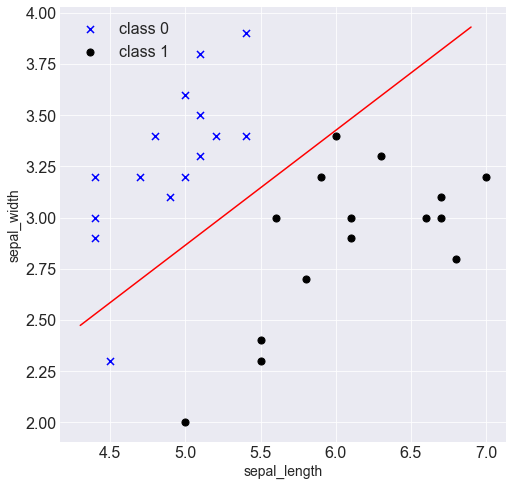

In [48]:
plt.figure(figsize=(8, 8))
# 散布図の表示
plt.scatter(x_t0[:, 1], x_t0[:, 2], marker='x',
            c='b', s=50, label='class 0')
plt.scatter(x_t1[:, 1], x_t1[:, 2], marker='o',
            c='k', s=50, label='class 1')
# 散布図に決定境界の直線も追記
plt.plot(xl, yl, c='red')
plt.xlabel('sepal_length', fontsize=14)
plt.ylabel('sepal_width', fontsize=14)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.show()

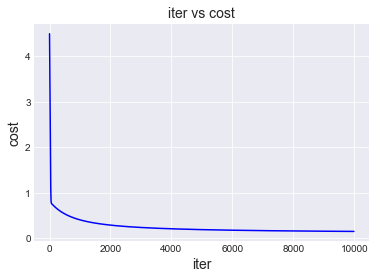

In [49]:
# 学習曲線の表示をします (損失関数)
plt.figure(figsize=(6, 4))
plt.plot(history[:, 0], history[:, 1], 'b')
plt.xlabel('iter', fontsize=14)
plt.ylabel('cost', fontsize=14)
plt.title('iter vs cost', fontsize=14)
plt.show()

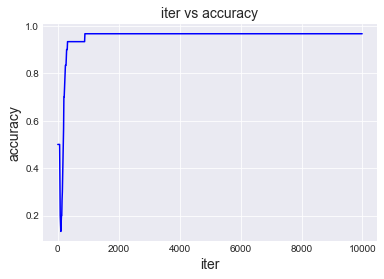

In [50]:
# 学習曲線の表示をします (精度)
plt.figure(figsize=(6, 4))
plt.plot(history[:, 0], history[:, 2], 'b')
plt.xlabel('iter', fontsize=14)
plt.ylabel('accuracy', fontsize=14)
plt.title('iter vs accuracy', fontsize=14)
plt.show()

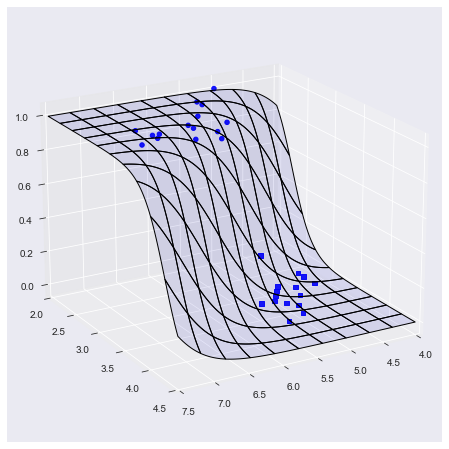

In [51]:
# 予測関数の3次元表示
from mpl_toolkits.mplot3d import Axes3D
x1 = np.linspace(4, 7.5, 100)
x2 = np.linspace(2, 4.5, 100)
xx1, xx2 = np.meshgrid(x1, x2)
xxx = np.asarray([np.ones(xx1.ravel().shape),
                  xx1.ravel(), xx2.ravel()]).T
c = pred(xxx, w).reshape(xx1.shape)
plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(xx1, xx2, c, color='blue',
                edgecolor='black', rstride=10, cstride=10, alpha=0.1)
ax.scatter(x_t1[:, 1], x_t1[:, 2], 1, s=20, alpha=0.9, marker='o', c='b')
ax.scatter(x_t0[:, 1], x_t0[:, 2], 0, s=20, alpha=0.9, marker='s', c='b')
ax.set_xlim(4, 7.5)
ax.set_ylim(2, 4.5)
ax.view_init(elev=20, azim=60)